# 4. Anomaly Detection - 基于相似度

## **Contents：**

1. density-based
2. density based

## 4.1 Overview

异常本质上是一种主观认定，哪一种数据被认为是异常要基于特定场景和特定环境。

在实际业务环境中，数据通常被嵌入在大量的噪音之中，而我们所说的“异常”是指在特定业务场景中具有特殊意涵的内容。而噪音可以被简单地视作为特性较弱的异常值，例如白噪音，通常没有分析的价值。

而具体来说，噪音和异常之间以及正常的数值和噪声之间的边界相对模糊，异常值往往具有更高的离群程度的分数，通常是概率和标准化的分值。同时，相比较噪音，异常值也更具有可解释性，这意味着异常值在特定业务场景中是有分析价值的。

在普通的数据处理中，我们通常需要保留正常的数值，忽略噪声和异常值。但是对于异常值检测来说，我们弱化噪声和正常数值之间的区别，专注于那些具有价值特性的异常值。

我们运用的基于相似度的方法中，异常值和正常点之间具有significant difference。

## 4.2 Distance-based Measures

基于距离的方法是非常常见的异常值检测算法，它运用最近邻距离来定义异常值。

这种方法具有如下几个特征：
1. 这种办法的时间复杂度一般是$O(n^2)$,随着问题规模的增大，效率会加速下降。
2. 因为threshold的设定是基于global distance的，所以这种算法不太适用于local outlier的检测，而主要注重在global outlier。
3. 这种方法虽然适用于高维数据，但是要求高维数据在其特种空间里呈现出pattern，随着维度上升，对于数据量的需求会增加；而问题规模增大也会导致运行速度加速下降。所以这是一个trade-off。

所以换句话说，这种基于距离的异常值检测算法适用于较小规模和维度较低的数据集，而且主要包含global outliers。

这种distance-based 方法经常用于分类数据、文本数据、时间序列和其他序列数据。

基于异常值的检测有前提条件：异常点的k个近邻距离（KNN）要远大于正常点。

解决这种问题的最直观的方法是利用循环嵌套：
points = {p_1,p_2,...,p_(k-1),p_(k),p_(k+1),...,p_n}

least_dist = $\epsilon$

least_count = $K$
```
for p_k in points:
    total_count = 0
    for p_m in points-p_k:
        distance_k2m = DIST(p_k,p_m)
        if distance_k2m <=least_dist:
            total_count+=1
        if total_count >=least_count:
            p_k -> normal
        else:
            p_k -> outlier
            
```

以上这种方法的时间复杂度是$O(n^2)$,不适用于比较大规模的问题。所以我们需要在以上方法的前提下，做一些修改。

### 4.2.1 基于单元的方法

在基于单元格的技术中，数据空间被划分为单元格，单元格的宽度是阈值D和数据维数的函数。具体地说，每个维度被划分成宽度最多为 $\frac{D}{{2 \cdot \sqrt d }}$ 单元格。在给定的单元以及相邻的单元中存在的数据点满足某些特性，这些特性可以让数据被更有效的处理。

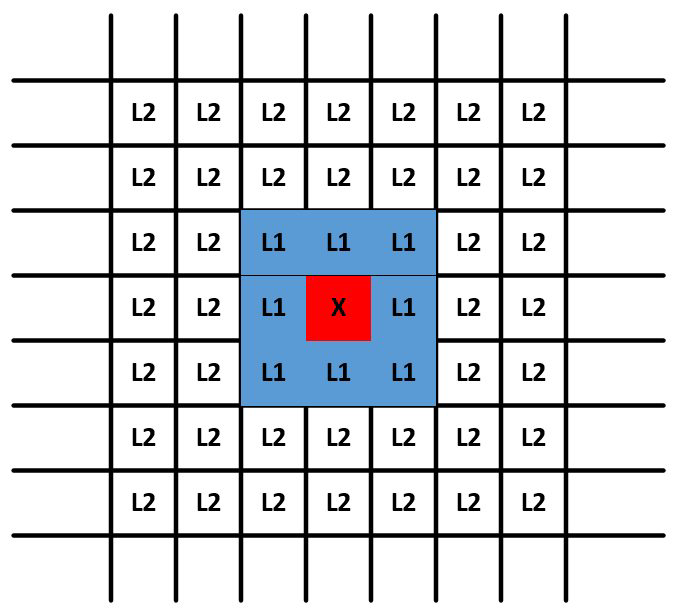

以二维情况为例，此时网格间的距离为 $\frac{D}{{2 \cdot \sqrt d }}$ ，需要记住的一点是，网格单元的数量基于数据空间的分区，并且与数据点的数量无关。这是决定该方法在低维数据上的效率的重要因素，在这种情况下，网格单元的数量可能不多。 另一方面，此方法不适用于更高维度的数据。对于给定的单元格，其 $L_{1}$ 邻居被定义为通过最多1个单元间的边界可从该单元到达的单元格的集合。请注意，在一个角上接触的两个单元格也是 $L_{1}$ 邻居。 $L_{2}$ 邻居是通过跨越2个或3个边界而获得的那些单元格。 上图中显示了标记为 $X$的特定单元格及其 $L_{1}$ 和 $L_{2}$ 邻居集。 显然，内部单元具有8个 $L_{1}$ 邻居和40个 $L_{2}$ 邻居。 然后，可以立即观察到以下性质：

1. 单元格中两点之间的距离最多为 $\sqrt{(\frac{D}{{2 \cdot \sqrt d }})^2*d}$ = $D/2$。
2. 一个点与 $L_{1}$ 邻接点之间的距离最大为 $D$。
3. 一个点与它的 $Lr$ 邻居(其中$r$ > 2)中的一个点之间的距离至少为$D$。

所以问题就变成了：
1. 对于一个数据点在$L_{1}$区域，则邻近距离一定小于阈值：$D$
2. 对于一个数据点在$L_{r}$ and r>2,则邻近距离一定大于等于阈值：$D$
3. 但是对于一个数据点在$L_{2}$区域，则邻近距离需要进一步计算

另外：我们还可以总结另外两条规律：
1. 如果一个单元格包含超过 $k$ 个数据点，那么这些数据点都不是异常值，并且其相邻的 $L_{1}$区域仅包含非异常值 。
2. 如果单元 $A$ 及其对应的所有 $L_{1}$ 和 $L_{2}$ 区域包含少于 $k$ 个数据点，则单元A中的所有点都是异常值。

第一条规律还可以引申出：如果一个单元格和其相邻的$L_{1}$区域包含超过$k$个数据点，则这些所有数据都是非异常值

最后，对于此时仍未标记为异常值或非异常值的单元格中的数据点需要明确计算其 $k$ 最近邻距离。即使对于这样的数据点，通过使用单元格结构也可以更快地计算出 $k$ 个最近邻的距离。

考虑到目前为止尚未被标记为异常值或非异常值的单元格$A$。这样的单元可能同时包含异常值和非异常值。单元格 $A$ 中数据点的不确定性主要存在于该单元格的 $L_{2}$ 邻居中的点集。无法通过规则知道 $A$ 的 $L_{2}$ 邻居中的点是否在阈值距离 $D$ 内，为了确定单元 $A$ 中数据点与其$L_{2}$ 邻居中的点集在阈值距离 $D$ 内的点数，需要进行显式距离计算。对于那些在 $L_{1}$ 和 $L_{2}$ 中不超过 $k$ 个且距离小于 $D$ 的数据点，则声明为异常值。需要注意，仅需要对单元 $A$ 中的点到单元$A$的$L_{2}$邻居中的点执行显式距离计算。这是因为已知 $L_{1}$ 邻居中的所有点到 $A$ 中任何点的距离都小于 $D$，并且已知 $Lr$ 中 $(r> 2)$ 的所有点与 $A$上任何点的距离至少为 $D$。因此，可以在距离计算中实现额外的节省。

所以总结来说：**这种方法运用了迭代剪枝来加速运行效率**。

### 4.2.2 基于索引的方法

对于一个给定数据集，基于索引的方法利用多维索引结构(如 $\mathrm{R}$ 树、$k-d$ 树)来搜索每个数据对象 $A$ 在半径 $D$ 范围 内的相邻点。

例如k-d树，k-d树运用二叉树的特质和回溯的方法可以快速求得一个点最邻近的点。我们可以利用k-d树的特质来求某个点$A$半径为$D$的空间中的数据点的个数。

设 $M$ 是一个异常值在其 $D$ -邻域内允许含有对象的最多个数，若发现某个数据对象 $A$ 的 $D$ -邻域内出现 $M+1$ 甚至更多个相邻点， 则判定对象 $A$ 不是异常值。该算法时间复杂度在最坏情况下为 $O\left(k N^{2}\right),$ 其中 $k$ 是数据集维数， $N$ 是数据集包含对象的个数。该算法在数据集的维数增加时具有较好的扩展性，但是时间复杂度的估算仅考虑了搜索时间，而构造索引的任务本身就需要密集复杂的计算量。

## 4.3 Density-based Measures

基于密度的算法主要有局部离群因子(LocalOutlierFactor,LOF)，以及LOCI、CLOF等基于LOF的改进算法。下面我们以LOF为例来进行详细的介绍和实践。

  基于距离的检测适用于各个集群的密度较为均匀的情况。在下图中，离群点B容易被检出，而若要检测出较为接近集群的离群点A，则可能会将一些集群边缘的点当作离群点丢弃。而LOF等基于密度的算法则可以较好地适应密度不同的集群情况。

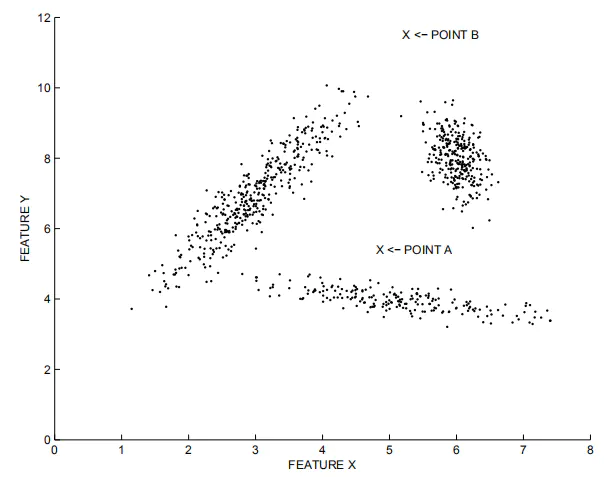

**LOF的基本参数和概念：**

**1. k-距离(k-distance(p)):**

    对于数据集D中的某一个对象o，与其距离最近的k个相邻点的最远距离表示为k-distance(p)，定义为给定点p和数据集D中对象o之间的距离d(p,o)，满足：

   $(1) $ 在集合D中至少有k个点 o'，其中$o'∈D{p}$，满足$d(p,o')≤d(p,o)$
    
   $(2) $ 在集合D中最多有k-1个点o'，其中$o'∈D{p}$，满足$d(p,o';)<d(p,o)$
    
    直观一些理解，就是以对象o为中心，对数据集D中的所有点到o的距离进行排序，距离对象o第k近的点p与o之间的距离就是k-距离。

**2. k-邻域（k-distance neighborhood）：**

   对象o的距离小于等于k-距离的所有点的集合，我们称之为k-邻域：
   $N_{k−d i s t a n c e ( p )}( P ) = { q∈D\backslash{p}|d(p,q)≤ k-distance(p)} $。

   在二维平面上展示出来的话，对象o的k-邻域实际上就是以对象o为圆心、k-距离为半径围成的圆形区域。就是说，k-邻域已经从“距离”这个概念延伸到“空间”了。示意图如下：

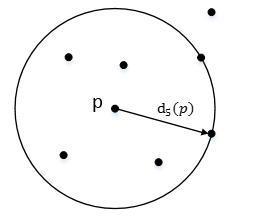

**3. 可达距离（reachability distance）：**

 有了邻域的概念，我们可以按照到对象o的距离远近，将数据集D内的点按照到o的距离分为两类:
 
   1) 若$p_i$在对象o的k-邻域内，则可达距离就是给定点p关于对象o的k-距离；

   2) 若$p_i$在对象o的k-邻域外，则可达距离就是给定点p关于对象o的实际距离。

给定点p关于对象o的可达距离用数学公式可以表示为：$r e a c h−d i s t_ k ( p , o ) = \max({k−distance(o),d(p ,o)})$ 。
  
这样的分类处理可以简化后续的计算，同时让得到的数值区分度更高。

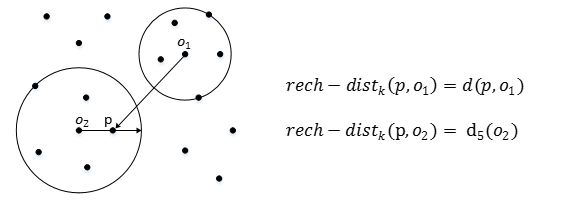

**4.局部可达密度（local reachability density）：**

  我们可以将“密度”直观地理解为点的聚集程度，就是说，点与点之间距离越短，则密度越大。在这里，我们使用数据集D中给定点p与对象o的k-邻域内所有点的可达距离平均值的倒数（注意，不是导数）来定义局部可达密度。
  
  给定点p的局部可达密度计算公式为：$$lrd_k(p) = 1 / (\frac{\sum_{o \in N_{k}(p)} reach-dist_k(p,o)}{|N_{k}(p)|}))$$

  由公式可以看出，这里是对给定点p进行度量，计算其邻域内的所有对象o到给定点p的可达距离平均值。给定点p的局部可达密度越高，越可能与其邻域内的点 属于同一簇；密度越低，越可能是离群点。

**5.局部异常因子：**

表示点p的邻域$N_k(p)$内其他点的局部可达密度与点p的局部可达密度之比的平均数。如果这个比值越接近1，说明o的邻域点密度差不多，o可能和邻域同属一簇；如果这个比值小于1，说明o的密度高于其邻域点密度，o为密集点；如果这个比值大于1，说明o的密度小于其邻域点密度，o可能是异常点。

$$LOF_k(p)=\frac{\sum_{o \in N_{k}(p)} \frac{lrd_k(o)}{lrd_k(p)}}{|N_k(p)|} = \frac{\sum_{o \in N_k(p)} lrd_k(o)}{|N_k(p)|} / lrd_k(p)$$


  最终得出的LOF数值，就是我们所需要的离群点分数。在sklearn中有LocalOutlierFactor库，可以直接调用。下面来直观感受一下LOF的图像呈现效果。

  LocalOutlierFactor库可以用于对单个数据集进行无监督的离群检测，也可以基于已有的正常数据集对新数据集进行新颖性检测。在这里我们进行单个数据集的无监督离群检测。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
np.random.seed(61)

# 构造两个数据点集群
X_inliers1 = 0.2 * np.random.randn(100, 2)
X_inliers2 = 0.5 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers1 + 2, X_inliers2 - 2]

# 构造一些离群的点
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# 拼成训练集
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
# 打标签，群内点构造离群值为1，离群点构造离群值为-1
ground_truth[-n_outliers:] = -1

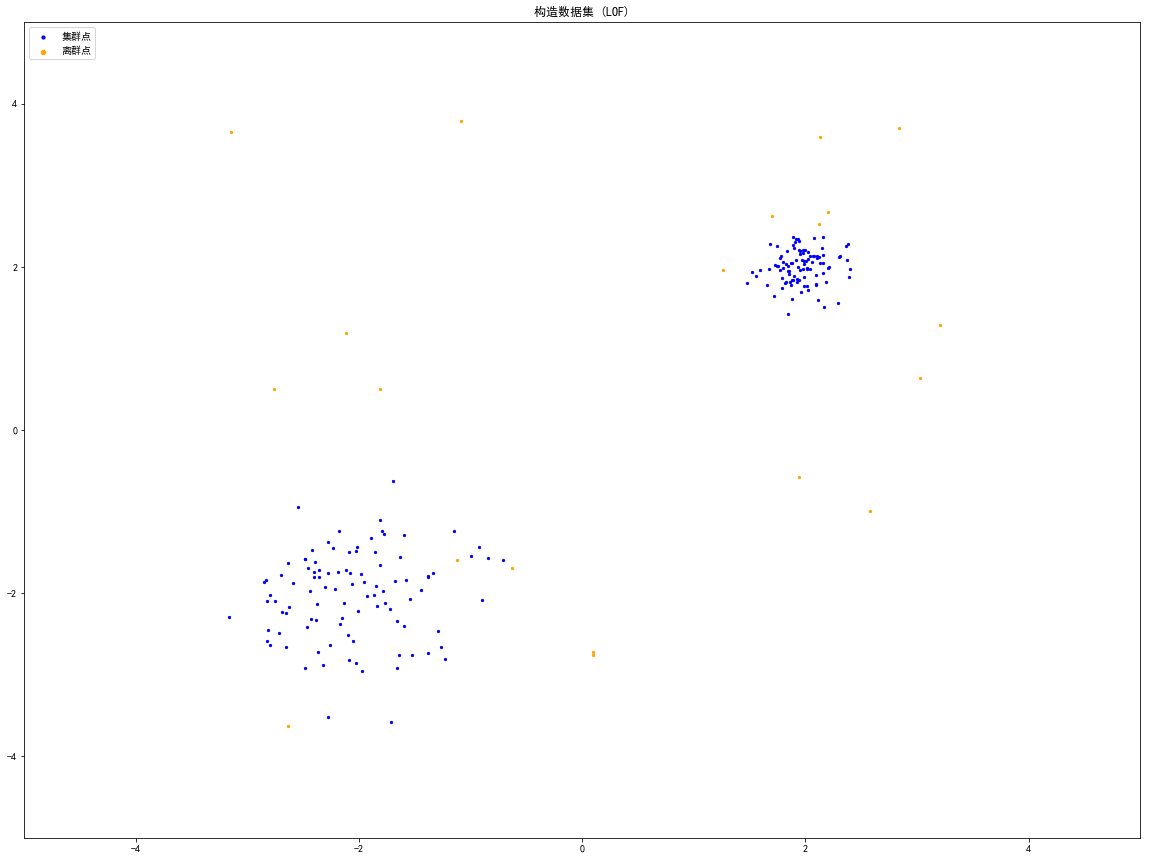

In [3]:
fig = plt.figure(figsize=(20,15))
plt.title('构造数据集 (LOF)')
plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], color='b', s=5, label='集群点')
plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='orange', s=5, label='离群点')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

Apply LOF to the train dataset

In [4]:
# 训练模型（找出每个数据的实际离群值）
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# 对单个数据集进行无监督检测时，以1和-1分别表示非离群点与离群点
y_pred = clf.fit_predict(X)

# 找出构造离群值与实际离群值不同的点
n_errors = y_pred != ground_truth
X_pred = np.c_[X,n_errors]

X_scores = clf.negative_outlier_factor_
# 实际离群值有正有负，转化为正数并保留其差异性（不是直接取绝对值）
X_scores_nor = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
X_pred = np.c_[X_pred,X_scores_nor]
X_pred = pd.DataFrame(X_pred,columns=['x','y','pred','scores'])

X_pred_same = X_pred[X_pred['pred'] == False]
X_pred_different = X_pred[X_pred['pred'] == True]

# 直观地看一看数据
X_pred.head(50)

,x,y,pred,scores
0,1.913701,2.087875,0.0,0.000494
1,1.999748,2.212225,0.0,0.005255
2,2.040673,2.133115,0.0,0.001521
3,1.791277,1.743218,0.0,0.015652
4,1.991693,1.770405,0.0,0.010113
5,1.974831,2.204030,0.0,0.005188
6,2.205924,1.986534,0.0,0.022802
7,1.880050,2.048036,0.0,0.002938
8,1.558993,1.886954,0.0,0.044276
9,2.308499,2.136235,0.0,0.034563


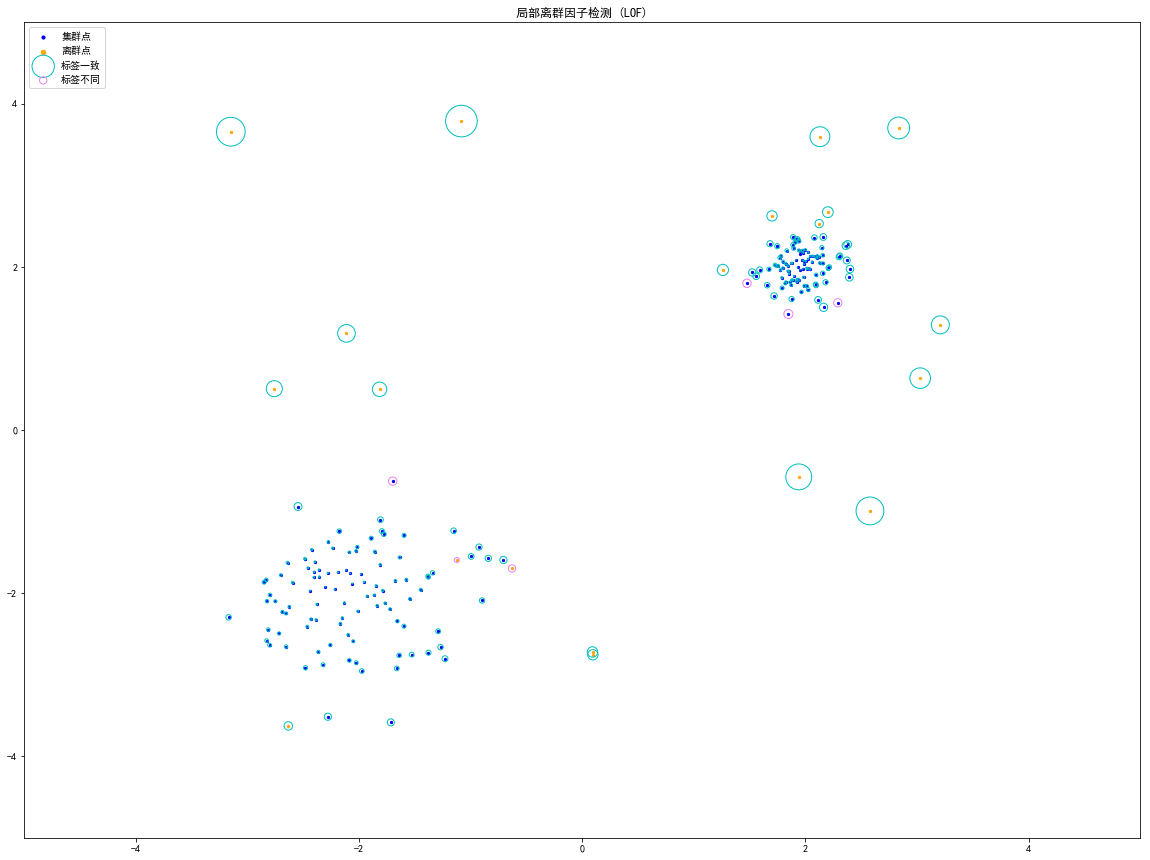

In [5]:
fig = plt.figure(figsize=(20,15))
plt.title('局部离群因子检测 (LOF)')
plt.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], color='b', s=5, label='集群点')
plt.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], color='orange', s=5, label='离群点')

# 以标准化之后的局部离群值为半径画圆，以圆的大小直观表示出每个数据点的离群程度
plt.scatter(X_pred_same.values[:,0], X_pred_same.values[:, 1], 
            s=1000 * X_pred_same.values[:, 3], edgecolors='c', 
            facecolors='none', label='标签一致')
plt.scatter(X_pred_different.values[:, 0], X_pred_different.values[:, 1], 
            s=1000 * X_pred_different.values[:, 3], edgecolors='violet', 
            facecolors='none', label='标签不同')

plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))

legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

**结果：**

模型成功区分出了大部分的离群点，但是一些因为随机原因散落在集群内部的“离群点”被识别为集群内部的点，而一些与集群略为分散的“集群点”则被识别为离群点。

另外，模型对于不同密度的集群可以自动调节密度阈值来区分集群的点和离群点。

所以，在某些情况下，LOF可能比基于某种统计学分布规则的识别更加符合实际情况。

## 4.4 练习

In [6]:
from pyod.models.lof import LOF
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
import warnings
warnings.filterwarnings(action='ignore')
contamination = 0.02
n_train = 800
n_test = 200

X_train, y_train, X_test, y_test = generate_data(n_train=n_train,
                                                  n_test=n_test,
                                                  n_features=2,
                                                  contamination=contamination,
                                                  random_state=42)


In [7]:
clf = LOF(n_neighbors=20,contamination=contamination)
clf.fit(X_train)
y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_

In [8]:
y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

In [9]:
clf_name = "LOF"
print("Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nTest Data:")
evaluate_print(clf_name, y_test, y_test_scores)

Training Data:
LOF ROC:0.9998, precision @ rank n:0.9375

Test Data:
LOF ROC:0.9936, precision @ rank n:0.75


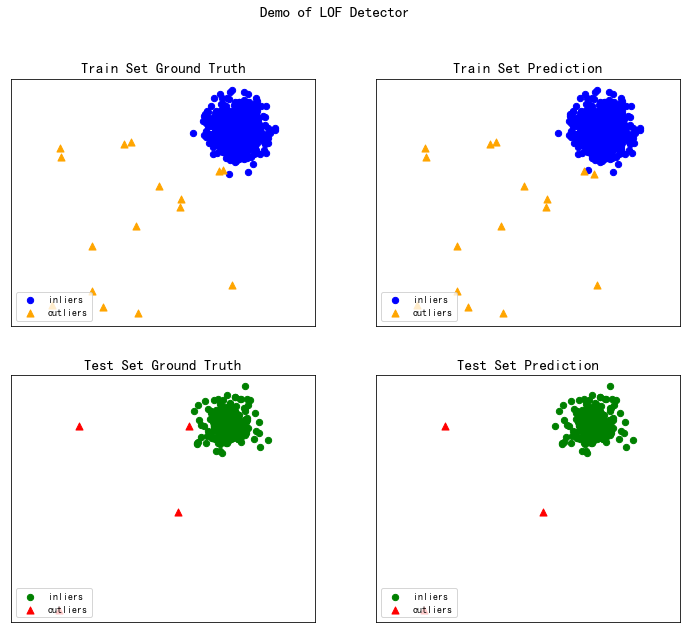

In [10]:
visualize(clf_name, X_train, y_train,
          X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True,
          save_figure=False)